In [1]:
import matplotlib.pyplot as plt
#plt.style.use('default')
import os
#os.environ['MONGO_PASSWORD'] = 'luxstinks'
import analyze
from channel_dict import channel_dict
import numpy as np
from matplotlib import cm
import os
import pandas as pd

In [2]:
def get_runlists():
    bottom_list = []
    topbulk_list = []
    topring_list = []
    for rl in os.listdir("./runlists"):
        with open("./runlists/" + rl) as f:
            runs = f.read().splitlines()
            bottom_list.append(int(runs[1]))
            topbulk_list.append(int(runs[2]))
            topring_list.append(int(runs[3]))
    
    return {"bottom" : bottom_list,
            "topbulk" : topbulk_list,
            "topring" : topring_list}

In [3]:
runlist_dict = get_runlists()

bottom_list = runlist_dict["bottom"]
topbulk_list = runlist_dict["topbulk"]

LED_spectrum = None
noise_spectrum = None
LED_amplitude = None
noise_amplitude = None
run_counter = 0
for run in topbulk_list:
    if run < 6731:
        continue
    datapath = "/project/lgrandi/xenon1t/spe_acceptance/data/run_%05d.h5" % run
    if not os.path.exists(datapath):
        print("Skipping run %d" % run)
        continue
    if LED_spectrum is None:
        df = pd.read_hdf(datapath)
        charge = df['bins'].values
        LED_spectrum = np.array(list(df['LED_charge'].values)).T
        noise_spectrum = np.array(list(df['noise_charge'].values)).T
        LED_amplitude = np.array(list(df['LED_amplitude'].values)).T
        noise_amplitude = np.array(list(df['noise_amplitude'].values)).T
    else:
        LED_spectrum += np.array(list(df['LED_charge'].values)).T
        noise_spectrum += np.array(list(df['noise_charge'].values)).T
        LED_amplitude = np.array(list(df['LED_amplitude'].values)).T
        noise_amplitude = np.array(list(df['noise_amplitude'].values)).T
        
    run_counter +=1
print("%d runs added to spectra" % run_counter)
        

99 runs added to spectra


In [4]:
print("LED entries: ", LED_spectrum.sum())
print("noise entries: ", noise_spectrum.sum())


LED entries:  4713732342.0
noise entries:  4727945376.0


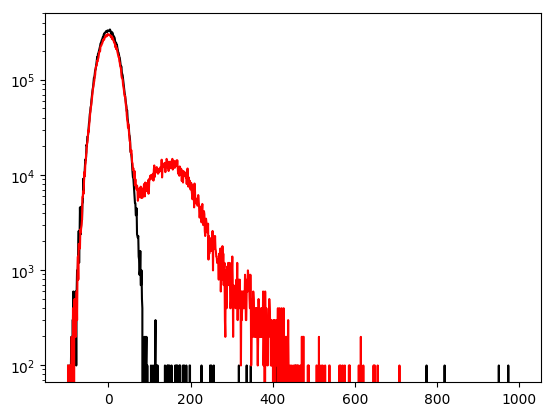

In [5]:
ch = 0
plt.plot(charge, noise_spectrum[ch], color='k')
plt.plot(charge, LED_spectrum[ch], color='r')
plt.yscale('log')
plt.show()

In [6]:
np.sum(noise_spectrum, axis=1).shape

(248,)

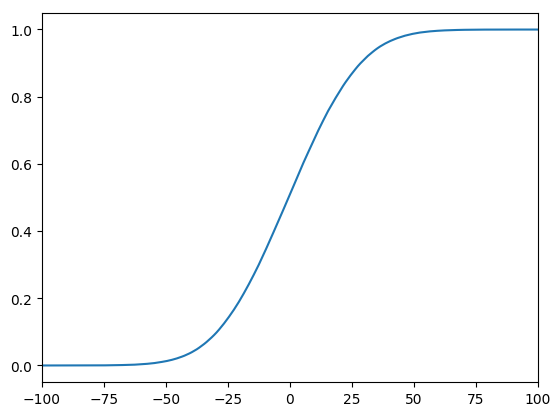

In [7]:
fs = np.cumsum(noise_spectrum, axis=1).T
fs = (fs / np.sum(noise_spectrum, axis=1)).T

plt.plot(charge, fs[0])
plt.xlim(-100, 100)
plt.show()

In [8]:
def correction_threshold(f, hist_array):
    """returns bin to correct to, given an f value and a noise spectrum"""
    fs = (np.cumsum(hist_array, axis=1).T/np.sum(hist_array, axis=1)).T
    return np.argmin(np.absolute(fs - f), axis=1)

corr_threshold = correction_threshold(0.3, noise_spectrum)

In [9]:

corr = []
for ch, thresh in enumerate(corr_threshold):
    corr.append(np.sum(LED_spectrum[ch, :thresh])/np.sum(noise_spectrum[ch, :thresh]))
corr = np.array(corr)
    
corr_noise = (noise_spectrum.T*corr).T


residual = LED_spectrum - corr_noise

occs = -np.log(corr)
off_channels = np.where(occs < 0.05)[0]

##for ch, (res, thresh) in enumerate(zip(residual, corr_threshold)):
#    res[np.where(charge < charge[thresh])] = 0 

In [10]:
off_channels = np.append(off_channels, [244])
off_channels

array([  1,   2,  12,  26,  34,  62,  65,  79,  86,  88, 102, 118, 130,
       134, 135, 139, 148, 150, 152, 162, 178, 183, 190, 198, 206, 213,
       214, 234, 239, 244])

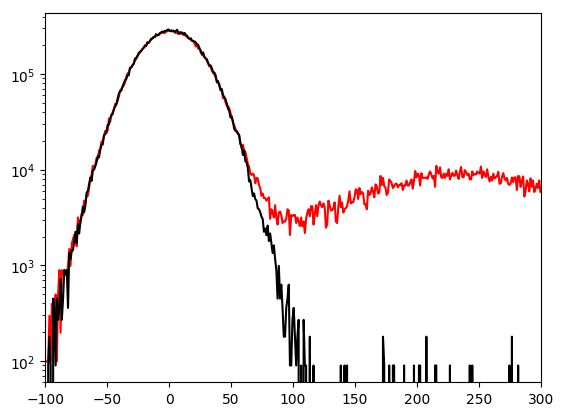

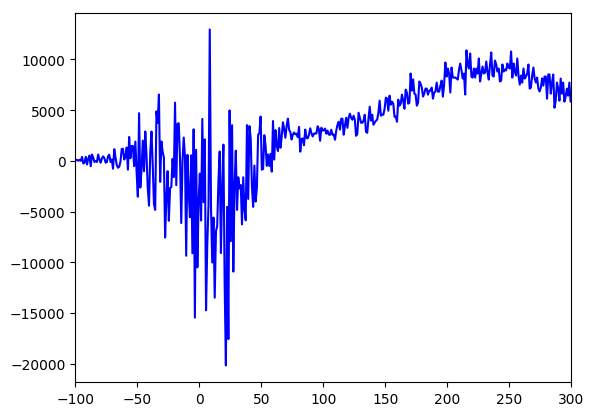

In [11]:
ch = 4

plt.plot(charge, LED_spectrum[ch], color='red')
plt.plot(charge, corr_noise[ch], color='black')
plt.xlim(-100, 300)
plt.yscale('log')
#plt.ylim(1e4, 3e4)
plt.show()


plt.plot(charge, residual[ch], color='blue')
plt.xlim(-100, 300)
plt.show()

In [12]:
from scipy.interpolate import UnivariateSpline

In [13]:
from scipy.optimize import curve_fit

def gauss(x, const, mu, sigma):
    G = const * np.exp(-(x-mu)**2 / (2*sigma**2))
    return G

def fit_with_gauss(xdata, ydata, xmin, xmax, first_guess = None):
    fit_xdata = [x for x in xdata if xmin<x<xmax]
    fit_ydata = [y for i,y in enumerate(ydata) if xmin<xdata[i]<xmax]
    assert len(fit_xdata) == len(fit_ydata)
    par_bounds = ([0, -np.inf, 0], [np.inf, np.inf, np.inf])
    pars, cov = curve_fit(gauss, fit_xdata, fit_ydata, first_guess, bounds = par_bounds)
    return pars, cov

In [14]:
def smooth(residual):
    smoother = []
    for ch, r in enumerate(residual):
        smoother.append(UnivariateSpline(charge, r.clip(min=0), s=5e8)(charge).clip(min=0))
    return smoother

smoothed = smooth(residual)

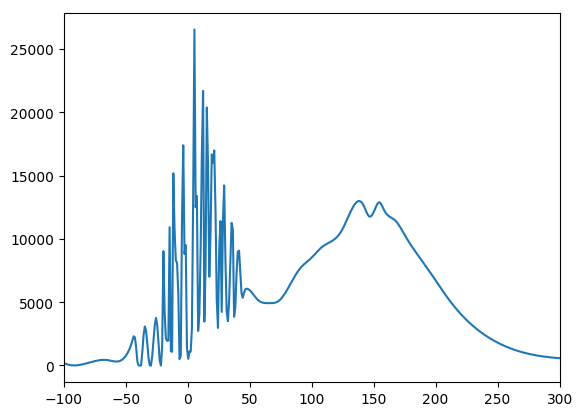

[1000.0, 114.63147414764181, 26.766522251177143]
[ 12384.93467654    147.08569178     51.97628043]


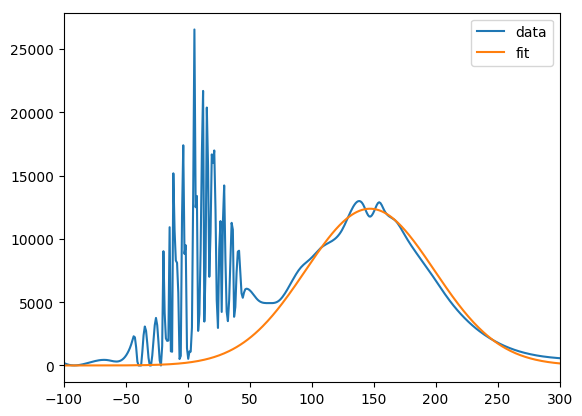

In [15]:
ch = 20
plt.plot(charge, smoothed[ch])
plt.xlim(-100, 300)
plt.show()


spe_dist = smoothed[ch]

mu = np.sum(spe_dist*charge) / np.sum(spe_dist)
sig = 2.5*np.sqrt(mu)
first_guess = [1e3, mu, sig]
print(first_guess)
popt,pcov = fit_with_gauss(charge,spe_dist, mu-(mu/150)*sig, mu+(mu/50)*sig, first_guess=first_guess)

print(popt)
fit = [gauss(x, *popt) for x in charge]
plt.plot(charge, spe_dist, label='data')
plt.plot(charge, fit, label='fit')
plt.legend()
plt.xlim(-100, 300)
plt.show()

In [16]:
from tqdm import tqdm

massaged = []
test_ch = -999
    
for ch, s in tqdm(enumerate(smoothed)):
    if ch in off_channels:
        massaged.append(np.zeros_like(charge))
        continue
    
    mu = np.sum(s*charge) / np.sum(s)
    
    underamp_bins = np.where(charge<20)[0]
    underamp_frac = np.sum(s[underamp_bins]) / np.sum(s)
    
    twoPE = np.where(charge > 2.5*mu)[0]
    twoPE_frac = np.sum(s[twoPE]) / np.sum(s)
    
    mu_mult = 1 + (underamp_frac < 0.25)*underamp_frac 
    
    
    if 300 < mu:
        factors = [1, 2, 3, 1.5]
    elif 200 < mu < 300:
        factors = [1.0, 3, 2.5, 1.2]
    elif 150 < mu < 200:
        factors = [1.0, 3, 2.5, 1.5]
    elif 125 < mu < 150:
        factors = [1.0, 3, 1.8, 1.3]
    elif 100 < mu < 125:
        factors = [1.0, 3, 1.5, 1.5]
    elif 70 < mu < 100:
        factors = [0.95, 3, 1.5, 1.4]
    elif mu < 70:
        factors = [1, 4, 1.75, 1.4 ]
        
    if ch == 209:
        factors[0] = 0.9
    try: 
        newmu = mu_mult*factors[0] * mu
        sig = factors[1] * np.sqrt(newmu)
        first_guess = [1e3, newmu, sig]
        left = newmu-factors[2]*sig
        right = newmu+factors[3]*sig
        
        popt,pcov = fit_with_gauss(charge,s, left, right, first_guess=first_guess)
        fit = gauss(charge, *popt)
        
    except RuntimeError:
        print('Except!')
        print('Ch %d' % ch)
        print(mu, newmu, sig)
        print(underamp_frac, twoPE_frac, mu_mult)
        plt.plot(charge, s)
        plt.xlim(-100, 400)
        plt.axvline(left, color='k')
        plt.axvline(right, color='k')
        plt.axvline(newmu, color='grey', linestyle='--')
        plt.axvline(20, color='red')
        plt.show()
        raise
    
    spe_dist = [s*(c<popt[1]+popt[2]) + f*(c>=popt[1]+popt[2]) 
                for s, f, c in zip(s, fit, charge)]
    
    if ch == test_ch:
        plt.plot(charge, s, color='black', linewidth=4)
        plt.plot(charge, fit, color='navy')
        plt.plot(charge, spe_dist, color='red')
        plt.xlim(-100, 400)
        plt.axvline(popt[1] + popt[2])
        plt.show()
        break
        
    

    
    massaged.append(spe_dist)
                               
    
    

248it [00:10, 23.36it/s]


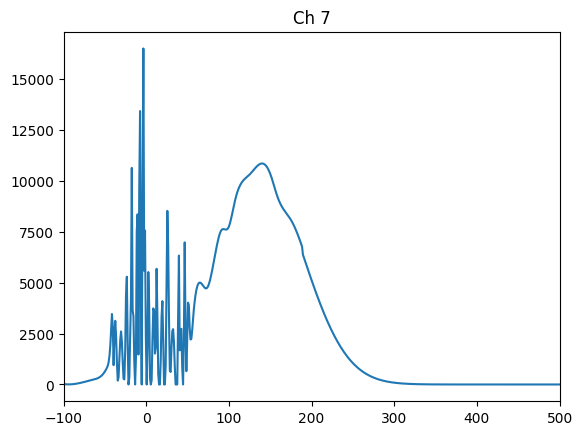

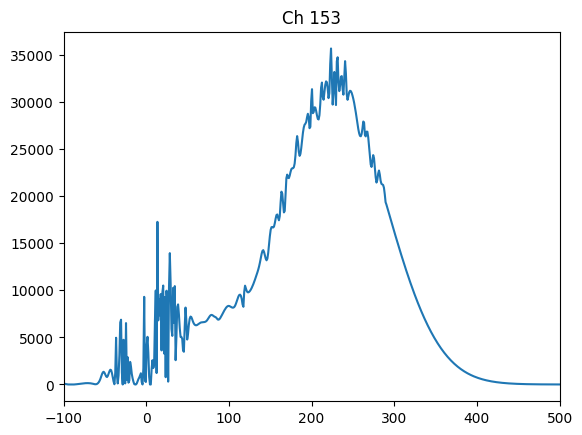

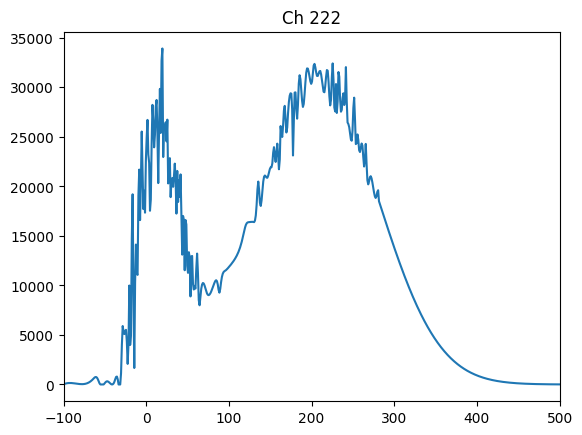

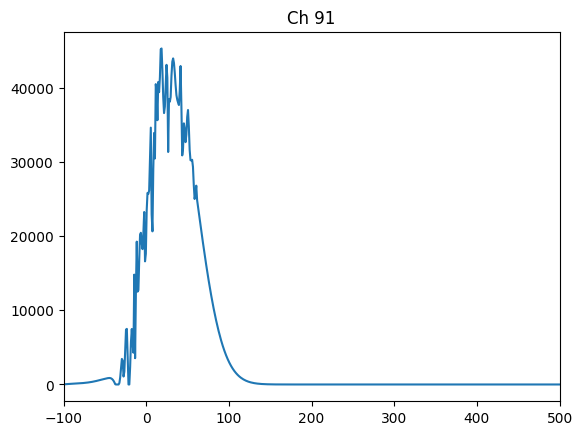

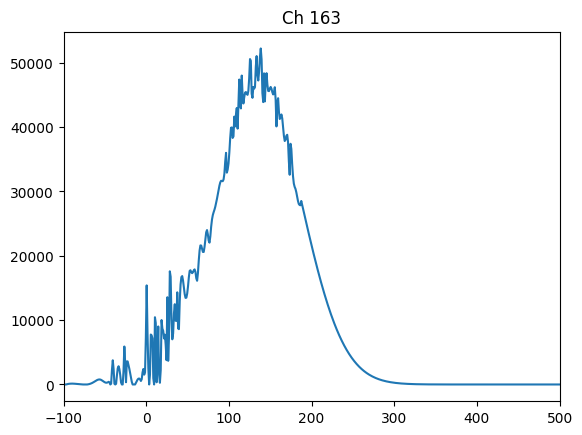

In [17]:
chs = np.random.choice(np.arange(248), size=5)

for ch in chs:
    plt.plot(charge, massaged[ch])
    plt.title('Ch %d' % ch)
    plt.xlim(-100, 500)
    plt.show()

In [18]:
from scipy.interpolate import interp1d

avg_charge = np.linspace(-2, 5, 10000)

averages = np.zeros_like(avg_charge)

for ch, curve in enumerate(massaged):
    if np.sum(curve) == 0.0:
        continue
    mu = np.sum(charge*curve) / np.sum(curve)
    this_norm = charge / mu
    interp = interp1d(this_norm, curve, bounds_error=False, fill_value=0.0)
    new_avg = interp(avg_charge)
    averages += interp(avg_charge)
    #if ch % 20 == 0:
    #    plt.plot(avg_charge, averages)
    #    plt.show()
averages /= np.sum(averages)        

# save average to a npz file
file = "/home/ershockley/avg_spe_gain.npz"
np.savez(file, bins=avg_charge, average=averages)

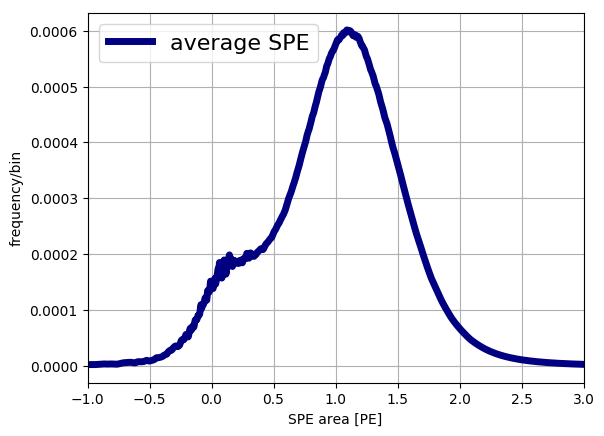

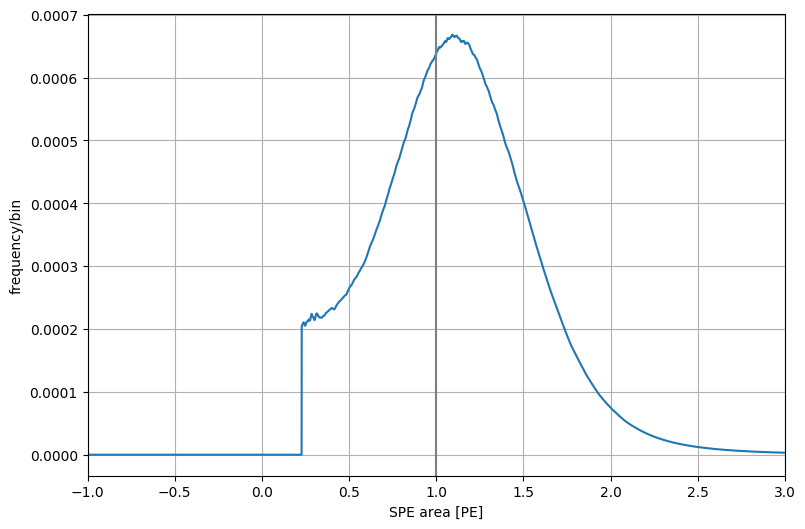

In [19]:
spe = 0.90
p = 1 - spe

cumulative = np.cumsum(averages)
arr = np.absolute(cumulative - p)
cut = avg_charge[np.where(arr == min(arr))]

cut_averages = averages.copy()
cut_averages[np.where(avg_charge < cut)] = 0

missed_averages = averages.copy()
missed_averages[np.where(avg_charge > cut)] = 0

cut_averages = cut_averages / cut_averages.sum()
missed_averages = missed_averages / missed_averages.sum()
averages = averages / averages.sum()

plt.figure(facecolor="white")
plt.plot(avg_charge, averages, color='navy', linewidth=5, label='average SPE')
#plt.plot(avg_charge, cut_averages, color='orange', label='clipped SPE')
#plt.axvline(1, color='grey')
plt.xlim(-1,3)
plt.xlabel('SPE area [PE]')
plt.ylabel('frequency/bin')
plt.grid()
plt.legend(fontsize=16)
plt.savefig('avg_spe.png')
plt.show()

plt.figure(figsize=(9,6))
plt.plot(avg_charge, cut_averages)
plt.axvline(1, color='grey')
plt.xlim(-1,3)
plt.xlabel('SPE area [PE]')
plt.ylabel('frequency/bin')
plt.grid()
plt.show()

cumulative_clip = np.cumsum(cut_averages)
cumulative_all = np.cumsum(averages)
cumulative_missed = np.cumsum(missed_averages)
np.savez('average_spe_gain.npz', x=avg_charge, y=averages)

In [20]:
# now need to pull from this
from scipy import stats

interp_clipped = interp1d(cumulative_clip, avg_charge)
interp_all = interp1d(cumulative_all, avg_charge)
interp_missed = interp1d(cumulative_missed, avg_charge)

def pull_spe_clipped(size=1):
    r = stats.uniform.rvs(size=size)
    return interp_clipped(r)

def pull_spe_all(size=1):
    r = stats.uniform.rvs(size=size)
    return interp_all(r)

def pull_spe_missed(size=1):
    r = stats.uniform.rvs(size=size)
    return interp_missed(r)

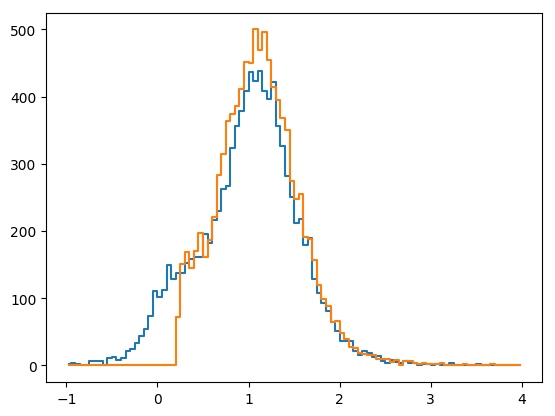

In [21]:
N = 10000
data = pull_spe_all(size=N)
data_clipped = pull_spe_clipped(size=N)

hist, bins = np.histogram(data, bins=100, range=(-1,4))
clipped_hist, bins = np.histogram(data_clipped, bins=100, range=(-1,4))

bins = 0.5*(bins[1:]+bins[:-1])

plt.plot(bins, hist, drawstyle='steps-mid')
plt.plot(bins, clipped_hist, drawstyle='steps-mid')
plt.show()

In [29]:
# do toyMC to simulate SPE acceptance loss in area space

N = 1000

photons = np.arange(1, 20, 1)

accs = []

charge_all = []
charge_pass = []

true_charge_all = []
true_charge_pass = []

measured_charge_all = []
measured_charge_pass = []

missed_pe_areas = []
frac = []
total_simmed = N*np.ones_like(photons)
missed = np.zeros_like(photons)

for i, ph in enumerate(photons):
    photons_triggered = stats.binom.rvs(n=ph, p=spe, size=N)
    missed[i] = np.sum(photons_triggered == 0)
    for hits in photons_triggered:
        if hits < ph:
            pe_missed = np.sum(pull_spe_missed(size=(ph-hits))) 
            missed_pe_areas.append(pe_missed)
        else:
            pe_missed = 0
            
        # only add to charge_all if peak found
        if hits == 0:
            pe_measured = 0
        else:
            pe_measured = np.sum(pull_spe_clipped(size=hits)) 
            charge_all.append(pe_measured)
            
            if hits > 2:
                charge_pass.append(pe_measured)
                       
        pe_true = pe_measured + pe_missed
        true_charge_all.append(pe_true)
        
        if hits > 2:
            true_charge_pass.append(pe_true)


file = 'datadriven_missed.npz'
np.savez(file, photons=photons, missed=missed, total=total_simmed)

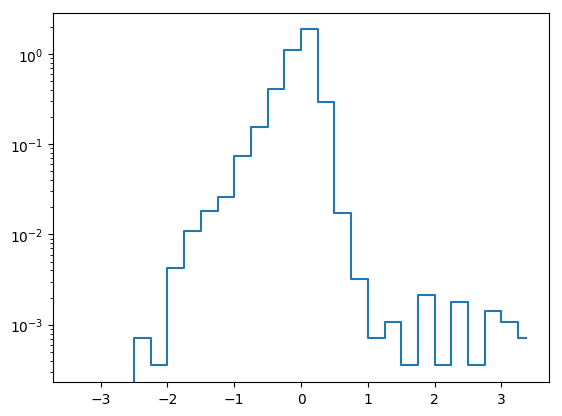

In [32]:
hist, bins = np.histogram(missed_pe_areas, range=(-3.5,3.5), bins=28, normed=True)
#dist = hist.sum() * missed_averages

bins = 0.5*(bins[1:]+bins[:-1])

plt.plot(bins, hist, drawstyle='steps-mid')
plt.yscale('log')
plt.show()

In [25]:
def binom_interval(success, total, confint=0.95):
    quantile = (1 - confint) / 2.
    lower = stats.beta.ppf(quantile, success, total - success + 1)
    upper = stats.beta.ppf(1 - quantile, success + 1, total - success)
    return (lower, upper)

In [30]:

plt.figure(figsize=(9,6))
plt.plot(bins, charge_all, drawstyle='steps-mid', color='navy', label='clipped total')
plt.plot(bins, charge_pass, drawstyle='steps-mid', color='cyan', label='clipped found')
plt.plot(bins, true_charge_all, drawstyle='steps-mid', color='maroon', label='true total')
plt.plot(bins, true_charge_pass, drawstyle='steps-mid', color='red', label='true found')
plt.xscale('log')
plt.xlim(1,10)
plt.grid(which='both')
plt.legend()
plt.show()


ValueError: x and y must have same first dimension, but have shapes (28,) and (18869,)

In [ ]:
from matplotlib import gridspec

all_hist, bins = np.histogram(charge_all, bins=80, range=(-0.5, 19.5))
detected_hist, bins = np.histogram(charge_pass, bins=80, range=(-0.5, 19.5))

true_all, bins = np.histogram(true_charge_all, bins=80, range=(-0.5, 19.5))
true_detected, bins = np.histogram(true_charge_pass, bins=80, range=(-0.5, 19.5))

bins = 0.5*(bins[1:]+bins[:-1])

acc_area = detected_hist/all_hist

lower, upper = binom_interval(detected_hist, all_hist, confint=(0.9))
lower = acc_area - lower
upper = upper - acc_area

true_acc_area = true_detected/true_all

true_lower, true_upper = binom_interval(true_detected, true_all, confint=(0.9))
true_lower = true_acc_area - true_lower
true_upper = true_upper - true_acc_area

##############
## Plotting ##
##############

gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 
f = plt.figure(figsize=(12,9))

ax1 = plt.subplot(gs[0])
ax1.errorbar(bins, acc_area, yerr=(lower, upper), linestyle='None', color='navy', label='reconstructed area',
             marker='.')
ax1.errorbar(bins, true_acc_area, yerr=(true_lower, true_upper), linestyle='None', color='red',
             label='true area',  marker='.')
ax1.set_xscale('log')
ax1.set_xlim(1,5)
ax1.grid(which='both')
ax1.set_ylim(0,1.01)
#ax1.set_xlabel('area [PE]')
ax1.set_ylabel('fraction passing coincidence thresh.')
ax1.legend(fontsize=14, loc=('upper left'))

approx_error = 0.5*(lower + upper)
approx_error_true = 0.5*(true_lower + true_upper)
approx_frac_errors = np.sqrt(approx_error**2 + approx_error_true**2) 

mean_of_the_fracs = 0.5*(acc_area + true_acc_area)

frac_lower = np.sqrt(lower/true_acc_area)
plt.setp(ax1.get_xticklabels(), visible=False)
ax2 = plt.subplot(gs[1])
#ax2.plot(bins, acc_area/true_acc_area-1, linestyle='--', drawstyle='steps-mid', color='gray', label='bias')
ax2.errorbar(bins, (acc_area - true_acc_area)/mean_of_the_fracs, yerr=approx_frac_errors,linestyle='None', 
             drawstyle='steps-mid', color='black', label='bias' )
ax2.set_xlim(1,5)
ax2.set_xscale('log')
ax2.grid(which='both')
ax2.set_ylim(-0.25,0.25)
ax2.set_xlabel('area [PE]')
ax2.set_ylabel('rel. diff.')
ax2.axhline(0, color='gray', linestyle='--')
yticks = ax2.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
plt.subplots_adjust(hspace=.0)
plt.savefig('plots/relative_error_recoarea.pdf')
plt.savefig('plots/relative_error_recoarea.png')
plt.show()

file='npzs/spe_acceptance_pe.npz'
np.savez(file, bins=bins, acceptance=acc_area, lower=lower, upper=upper, found=detected_hist, total=all_hist)

file='npzs/spe_acceptance_truepe.npz'
np.savez(file, bins=bins, acceptance=true_acc_area, lower=true_lower, upper=true_upper, 
         found=true_detected, total=true_all)



In [ ]:
### WHAT WE EXPECT FROM BINOMIAL ###
dpe = 0.15
adj_p = 1*dpe + spe*(1-dpe)
ns = np.linspace(0, 10, 11)
acc = stats.binom.sf(2, photons, spe)
####################################

In [ ]:
off_channels = np.where(-np.log(corr) < 0.05)[0]
on_channels = np.intersect1d(np.arange(248), off_channels)
on_channels

In [ ]:
smoothed = smoothed[on_channels]
for ch, smoo in enumerate(smoothed):
    mean = np.sum(charge*smoo)/np.sum(smoo)
    first_guess = [max(smoo), mean, np.sqrt(mean)]
    rng = (mean - np.sqrt(mean), mean+np.sqrt(mean))
    popts, pcov = fit_with_gauss(charge, smoo, *rng, first_guess=first_guess)
    print(popts)

In [ ]:
new_spe = []
for i, (b, spe) in enumerate(zip(charge,spe_dist)):
    if b<popt[1]+popt[2]:
        if b<-50:
            new_spe.append(0.0)
        else:
            new_spe.append(spe)
    else:
        new_spe.append(fit[i])
        
new_spe = np.array(new_spe)


In [ ]:
plt.plot(charge, spe_dist)
plt.plot(charge, new_spe)
plt.show()

In [ ]:
spe = new_spe
spe = spe / spe.sum()
print(spe.sum())

In [ ]:
plt.plot(charge, spe)
plt.xlabel('charge [count*samples]')
plt.savefig('sample_spe_dist.png')
plt.show()

In [ ]:
with open('spe_distribution.csv', "w") as f:
    for c, p in zip(charge, spe):
        f.write("%0.1f, %0.6f\n" % (c,p)) 